# **A CONCEPTUAL TEXT ANALYZER-CLUSTERER**

### Aydin Manzouri, 2025

---



# **SUMMARY**

<br>

This notebook provides a demo toolbox for conceptual analysis and clustering of text data.

<br>

## **Objective**

*To analyze and cluster texts based on their conceptual loads, via a hybrid concept-aggregate approach*

<br>

## **Contents**

It offers the following:

### (A) General

a.1.   Utilizes `spaCy` for NLP <br><br>
a.2.   Works with a hard-coded sample `concept_lexicon`, which is an aggregate-concept dictionary with entries:
```
"aggregate": ['concept_1', 'concept_2', ...]
```
<br>

a.3. Is capable of working with both single docs and batches <br><br>

### (B) Working with single documents

b.1. Function `analyze_txt` integrates the pipeline for *single* docs as: <br><br>

`filepath` → `read_txt` → `nlp` → `token_ext` → `concept_matcher` → `concept_aggregator`
<br><br>
b.2. `concept_aggregator` gives a tuple `(detailed, aggregated)` of data <br><br>
b.3. Functions `json_saver` and `json_loader` enable saving and loading the above data tuple in `JSON` format, resp. <br><br>
b.4. Function `aggreg_visu` generates and saves a bar chart from `aggregated` <br><br>
b.5. And function `concept_heatmap` generates and saves a heatmap from `detailed` <br><br>

### (C) Working with multiple documents

c.1. Function `batch_preprocess` loads multiple text files and prepares the data for the next steps <br><br>
c.2. Function `batch_plot` generates a batch of a couple of both plot types <br><br>
c.3. Functions `batch_json_saver` and `batch_json_loader` are batch-process analogs of their respective single-process functions <br><br>
c.4. Function `vectorizer` converts batch-preprocessed data into vectorized format to be used in ML operations. It combines detailed and aggregated data into a single `DataFrame` <br><br>
c.5. Finally, function `cluster` performs unsupervised learning, in the form of `KMeans` clustering. It:


*   receives data in vectorized format,
*   performs clustering,
*   applies PCA to high-dimensional data,
*   generates and saves the resulting 2D plot,
*   and returns a tuple `(df_combo, cluster_labels)`



---
<br><br>


In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_md

In [ ]:
import os
import spacy

nlp = spacy.load('en_core_web_md')

### **An Aggregate-Concept Dictionary** `concept_lexicon`

In [ ]:
# With entry format:
#                   "aggregate": ['concept_1', 'concept_2', ...]

# Though we work with this hard-coded dict here (in accordance with
# a fixed-sized heatmap, etc.), in future more scaled versions,
# it can be loaded from e.g. CSV files, of course

concept_lexicon = {
                   "environment": [
                                   'atmosphere', 'weather', 'sea', 'ocean',
                                   'river', 'air', 'water', 'land', 'forest',
                                   'mountain', 'desert', 'lake', 'city',
                                   'area', 'environment', 'temperature',
                                   'humidity', 'wind', 'sunshine', 'cloud'
                                  ],
                   "technology":  [
                                   'computer', 'mobile', 'telephone', 'watch',
                                   'wire', 'electricity', 'process',
                                   'irrigation', 'factory', 'car', 'machine',
                                   'truck', 'tv', 'phone', 'wireless',
                                   'technology', 'industry', 'work'
                                  ],
                   "humanity":    [
                                   'culture', 'economics', 'science',
                                   'justice', 'politics', 'psychology',
                                   'emotion', 'poll', 'money', 'public',
                                   'private', 'authority', 'salesman',
                                   'saleswoman', 'salesclerk', 'service',
                                   'tourism', 'banking', 'belief', 'taboo',
                                   'media', 'customer', 'philosophy',
                                   'intuition', 'family', 'wedding', 'divorce',
                                   'religion'
                                   ]
                  }

### **Concept Extractor, Matcher, & Aggregator Funs**

In [ ]:
def token_ext(doc):
  '''
  Token Extractor Function

  Accepts a `spaCy.Doc` object

  Returns the concept-worthy list of

  nouns and propositions present in the input
  '''

  # Extract nouns & propositions, and store them in lowercase
  tokens = [
            token.text.lower()
            for token in doc
            if (token.pos_ == "NOUN" or token.pos_ == "PROPN")
           ]

  return tokens

def concept_matcher(tokens):
  '''
  Concept Matcher Function
  Takes a list of lowercased tokens
  Matches the tokens against `concept_lexicon`
  Returns a dictionary showing which concepts appeared and how many times
  '''

  # Initialize the output dict
  occurrences = {}

  # Iterate over the keys of `concept_lexicon`
  for key in concept_lexicon.keys():

    # Iterate over the corresponding value
    for value in concept_lexicon[key]:

      # Make an entry in `occurrences` with:
      # `(key, value)` as key,
      # the number of occurrences as value
      occurrences[(key, value)] = sum(1 for word in tokens if word == value)

  return occurrences

def concept_aggregator(detailed_dict):
  '''
  Concept Aggregator Function
  Accepts dictionaries of the form `(key, subkey): number`
  Returns both the original `detailed_dict`
  and the aggregation of the occurrences
  '''

  from collections import defaultdict

  # Initialize a `defaultdict(int)` object
  counter = defaultdict(int)

  # Iterate over `detailed_dict`
  for (key, subkey), count in detailed_dict.items():

    # Increase the amount
    counter[key] += count

  return detailed_dict, dict(counter)  # converting `counter` to regular dict

### **The Aggregate Visualizer**

In [ ]:
def aggreg_visu(
                agg,
                p_show=True,
                filename="aggregated_concept_counts.png"
               ):
  '''
  Aggregate Visualizer Function

  Takes the 2nd component of the unpacked result from `concept_aggregator`

  Produces a `matplotlib` histogram (i.e. bar chart)

  Saves it to disk using the user-specified filename (with default)

  Also shows the output if desired (default Yes)

  Returns None
  '''

  import matplotlib.pyplot as plt

  # Figure
  fig, ax = plt.subplots()

  ax.bar(agg.keys(), agg.values())
  ax.set_title("Aggregated Concept Frequencies")
  ax.set_ylabel("Frequency")
  ax.set_xlabel("Aggregated Concept")

  plt.xticks(rotation=45)  # for cleaner output
  plt.tight_layout()
  plt.savefig(filename)

  # If show=True, then show the plot as well
  if p_show:
    plt.show()

  return None

### **The Concept Heatmap**

In [ ]:
def concept_heatmap(
                    occurrences,
                    p_show=True,
                    filename='concept_heatmap.png'
                   ):
  '''
  Concept Heatmap Function

  Accepts a detailed dict `occurrences`

  Converts it to a `pandas` dataframe

  Generates the corresponding heatmap

  Can be pipelined both to `concept_matcher`

  as well as to `concept_aggregator` via unpacking

  Saves the heatmap

  Also shows it if desired (default Yes)

  Returns None
  '''

  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sb

  # Step 1. Create a `dataframe` from the `(agg, concept): count` dict
  rows = []
  for (agg, concept), count in occurrences.items():

    rows.append({
                 'Aggregate': agg,
                 'Concept': concept,
                 'Count': count
               })

  df = pd.DataFrame(rows)

  # Step 2. Pivot the data for heatmap structure
  heatmap_data = df.pivot(
                          index='Aggregate',
                          columns='Concept',
                          values='Count'
                          ).fillna(0)

  # Step 3. Plotting the heatmap
  plt.figure(figsize=(20, 6))

  sb.heatmap(
      heatmap_data,
      annot=True,
      # cmap='YlGnBu',
      # cmap='viridis',
      # cmap='inferno',
      cmap='magma_r',
      fmt='g',
      linewidths=0.5
      )

  plt.title("Aggregate-Concept Heatmap")
  plt.tight_layout()

  # Step 4. Saving and showing
  plt.savefig(filename)

  # Step 5. If show=True, then show the plot as well
  if p_show:
    plt.show()

  return None

# **File-Processing Functions Pipelined:**

In [ ]:
def read_txt(filepath):
  '''
  Plaintext File Reader Function

  Accepts .txt files only

  Opens the specified `filepath` in read-only

  Returns the plaintext
  '''

  # check if .txt file
  if filepath.endswith('.txt'):

    # open file
    with open(filepath, 'r') as f:
      text = f.read()

  else:
    text = None
    print('Please give ".txt" files only!')

  return text

def analyze_txt(
    filepath,
    p_show=True,
    aggfile="aggregated_concept_counts.png",
    heatfile="concept_heatmap.png"
    ):

  '''
  Text Analyzer Function

  Accepts .txt files only

  Applies the
  `filepath` -> `read_txt` -> `nlp` -> `token_ext`
  -> `concept_matcher` -> `concept_aggregator`
  pipeline

  Generates the corresponding bar chart & heatmap plots

  Returns:
          {
            "detailed": {(aggregate, concept): count},
            "aggregated": {aggregate: count}
          }
  '''
  # check for .txt file
  if not filepath.endswith('.txt'):
    print('Please give ".txt" files only!')
    return None

  # the pipeline
  detailed, aggregated = concept_aggregator(
                         concept_matcher(
                         token_ext(
                         nlp(
                         read_txt(
                         filepath
                         )))))

  # plottings
  # aggregated bar chart
  print('\nAggregated bar chart generated\n\n')
  aggreg_visu(
              aggregated,
              p_show,
              aggfile
             )

  # detailed heatmap
  print('\n\nDetailed heatmap generated\n\n')
  concept_heatmap(
                  detailed,
                  p_show,
                  heatfile
                 )

  return {
          "detailed": detailed,
          "aggregated": aggregated
         }



---

# **The ML Pipeline**

---



### ML Step 1. **Preparing Multiple Text Files for Batch Processing**

In [ ]:
def batch_preprocess(folderpath):
  '''
  Batch Preprocessor Function

  Reads all .txt files in `folderpath` (NO DEFAULT)

  Applies the concept analysis pipeline to each

  Returns a list of file-wise results in the format:
          [{'filename': ..., 'detailed': ..., 'aggregated': ...}]
  '''

  # initialize
  results = []

  # iterate over the folder contents
  for filename in os.listdir(folderpath):

    # select .txt files
    if filename.endswith('.txt'):

      # create file path
      filepath = os.path.join(folderpath, filename)

      # read the content
      text = read_txt(filepath)

      # apply the concept aggregator pipeline
      detailed, aggregated = concept_aggregator(
                             concept_matcher(
                             token_ext(
                             nlp(
                             text
                             ))))

      # append
      results.append({
          "filename": filename,
          "detailed": detailed,
          "aggregated": aggregated
      })
      # end of for loop

  return results

### Side-Chain 1.A. **Batch Plotter**

In [ ]:
def batch_plot(
               batch_data,
               p_show=False,
               folderpath='./'
              ):
  '''
  Batch Plotter Function

  Takes the list of batch-preprocessed text files, of the format:
          [{'filename': ..., 'detailed': ..., 'aggregated': ...}]

  Applies `concept_heatmap` and `aggreg_visu` to each item
  (default show=False)

  Saves each plot using `folderpath` (with deafault) + 'filename'

  Returns None
  '''

  for i in range(len(batch_data)):

    name = y[i]['filename']

    # generate the filepath stem
    # 'filename.txt' -> `folderpath` joined to 'filename'
    filepath_stem = os.path.join(folderpath, name[:-4])

    aggreg_visu(
                y[i]['aggregated'],
                p_show,
                filename= filepath_stem + '_agg_barchart.png'
               )

    concept_heatmap(
                    y[i]['detailed'],
                    p_show,
                    filename=filepath_stem + '_detailed_heatmap.png'
                   )

    print(f'\nFile "{name}" done\n\n')
    # (end of for loop)

  return None

### Side-Chain 1.B. **JSON Utilities for Cross-Platform Data Management**

In [ ]:
def json_saver(
               data,
               output_path="converted_data.json"
              ):
  '''
  JSON Saver Function

  Receives `data` from the pipeline, which is NOT JSON

  Tuple keys in `detailed` must be converted to strings,
  and single quotes to double quotes in accordance with JSON, as the following:

  {"detailed": {"aggregate_|_concept": count}, "aggregated": {"aggregate": count}}

  Performs the conversion into JSON format
  Saves to `output_path` (with default)

  Returns None
  '''

  import json

  # convert tuple keys to strings, and `'` to `"`
  converted_data = {
                    "detailed": {
                                 f"{key[0]}_|_{key[1]}": value
                                 for key, value in data['detailed'].items()
                                },
                    "aggregated": data['aggregated']
                   }

  # Convert to JSON & save to file
  with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(converted_data, f, indent=4)

  return None

def json_loader(filepath="converted_data.json"):
  '''
  JSON Loader Function

  Loads the user-specified JSON `filepath` (with deafault)
  with the format:

  {"detailed": {"aggregate_|_concept": count}, "aggregated": {"aggregate": count}}

  Converts it back to the format:

          {
            "detailed": {(aggregate, concept): count},
            "aggregated": {aggregate: count}
          }

  Returns the result
  '''

  import json

  # check for .json file
  if not filepath.endswith('.json'):
    print('Please give ".json" files only!')
    return None

  # Load JSON file
  with open(filepath, 'r') as f:
    data = json.load(f)

  # Convert string keys to tuples in 'detailed'
  detailed_with_tuples = {
                          tuple(key.split('_|_')): value
                          for key, value in data['detailed'].items()
                         }

  # Combine 'detailed' with 'aggregated'
  result = {
            'detailed': detailed_with_tuples,
            'aggregated': data['aggregated']
           }
  return result


def batch_json_saver(
                     batch_data,
                     folderpath='./'
                    ):
  '''
  Batch JSON Saver Function

  Receives a batch of data in the format:
          [{'filename': ..., 'detailed': ..., 'aggregated': ...}]
  which corresponds to the return format of `batch_preprocess`

  Saves the list items using `json_saver` for each

  Performs the saving to the user-specified path (with default)

  Returns None
  '''

  # iterate over `batch_data`
  for data in batch_data:

    # get the filename
    name = data['filename']

    # 'filename.txt' -> `folderpath` joined to 'filename.'
    filepath_stem = os.path.join(folderpath, name[:-3])

    filepath = filepath_stem + 'json'

    # save
    json_saver(data, filepath)

    print(f'File {filepath} saved\n')

  return None

def batch_json_loader(folderpath='./'):
  '''
  Batch JSON Loader Function

  Loads a batch of JSON files with the format:

  {"detailed": {"aggregate_|_concept": count}, "aggregated": {"aggregate": count}}

  Returns a batch of data in the format:
          [{'filename': ..., 'detailed': ..., 'aggregated': ...}]
  '''

  # initialize
  batch_data = []

  # iterate over the folder contents
  for filename in os.listdir(folderpath):

    # select .json files
    if filename.endswith('.json'):

      # create file path
      filepath = os.path.join(folderpath, filename)

      # load json
      batch_data.append(json_loader(filepath))

  return batch_data

### ML Step 2. **Vectorization**

In [ ]:
def vectorizer(batch_prep):
  '''
  Vectorizer Function

  Takes the list of batch-preprocessed text files, of the format:
          [{'filename': ..., 'detailed': ..., 'aggregated': ...}]

  Performs vectorization for of `detailed` and `aggregated` separately

  Combines them in the format:
            pd.concat([df1, df2], axis=1)

  Returns the result
  '''

  import pandas as pd

  # unpacking
  length = len(batch_prep)
  filenames = []
  aggregated = []
  detailed = []
  for i in range(length):
    filenames.append(batch_prep[i]['filename'])
    aggregated.append(batch_prep[i]['aggregated'])
    detailed.append(batch_prep[i]['detailed'])


  # (a) aggregated features
  df_agg = pd.DataFrame(aggregated)

  # replace NaNs
  df_agg.fillna(0, inplace=True)

  # index
  df_agg.index = filenames


  # (b) detailed features
  # collecting all possible (agg, concept) pairs...
  # although we know that, e.g. detailed[0] captures this,
  # for more safety and code scalability, we take a hybrid approach;

  # firstly, collecting from detailed[0]:
  all_keys = set(detailed[0].keys())

  # and then, augmenting for any possible missed entry in the rest of the list:
  for entry in detailed[1:]:
    if len(entry.keys() - all_keys) > 0:
      all_keys |= entry.keys()

  # build rows for df_det, from detailed[i]
  rows = []

  for i in range(length):

    # fetch the value of `key` if existing, otherwise insert 0
    row = {key: detailed[i].get(key, 0) for key in all_keys}

    # appaned to the list of rows
    rows.append(row)

  # build df_det
  df_det = pd.DataFrame(rows, index=filenames)

  # replace NaNs
  df_det.fillna(0, inplace=True)


  # (c) combination by concatenating by index
  # check equality...
  assert all(df_agg.index == df_det.index)
  # and merge
  df_combo = pd.concat([df_agg, df_det], axis=1)

  return df_combo

In [ ]:
# ML Step 3. Clustering (Unsupervised Learning)

def cluster(
            df_combo,
            save_name="pca_plot.png"
           ):
  '''
  Clustering Function
  Accepts a hybridized DataFrame `df_combo`
  Uses KMeans
  Preprocesses `df_combo`
  Fits the model to data
  Adds cluster labels to `df_combo`
  Calculates and prints the Silhouette score
  Applies PCA to high-D data
  Plots the result
  Saves the plot to user-specified path
  Returns `df_combo`, `cluster_labels`
  '''
  # Step 3.1. Choosing a Clustering Algorithm

  # dos with `kmeans` (others for future work)
  from sklearn.cluster import KMeans
  from sklearn.preprocessing import StandardScaler
  from sklearn.decomposition import PCA
  from sklearn.metrics import silhouette_score as shs

  import matplotlib.pyplot as plt
  from matplotlib.colors import ListedColormap
  from matplotlib.patches import Patch

  # Step 3.2. Preprocessing the Hybrid DataFrame

  # get the filenames
  filenames = df_combo.index.tolist()

  scaler = StandardScaler()
  # converting df_combo columns to strings
  df_combo.columns = df_combo.columns.astype(str)

  # standardize
  scaled = scaler.fit_transform(df_combo)

  '''
  # Step 3.3. Determinig the Number of Clusters (Done Before the Main Run)

  # initialize a list of inertia values
  inertias = []

  # looping over a range of values
  for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled)
    inertias.append(kmeans.inertia_)

  # plotting to find an elbow point on the curve
  plt.plot(range(1, 11), inertias, marker='o')
  plt.xlabel('Number of clusters (k)')
  plt.ylabel('Inertia')
  plt.title('Elbow Method for Optimal k')
  plt.tight_layout()
  plt.show()

  # Based on the output elbow plot, k = 6 appears to be
  # the optimal point; so we proceed with this value
  '''

  # Step 3.4. Fitting the Clustering Model

  # initializing with k = 6
  kmeans = KMeans(n_clusters=6)
  # fit the model
  kmeans.fit(scaled)
  # get the labels
  cluster_labels = kmeans.labels_

  # Silhouette scoring
  score = shs(scaled, cluster_labels)
  print(f'\nSilhouette Score: {score}\n')

  # Step 3.5. Adding Cluster Labels to DataFrame

  df_combo.insert(
                  loc=0,
                  column='Cluster No.',
                  value=cluster_labels
                  )

  # Step 3.6. Visualization

  # setup color map for discrete clusters

  # get the number of clusters
  num_clusters = len(set(cluster_labels))

  # get cmap and define the color list
  cmap = plt.get_cmap('Set1')
  colors = [cmap(i) for i in cluster_labels]


  # PCA for dimensionality reduction to 2
  pca = PCA(n_components=2)

  # apply the transform
  reduced = pca.fit_transform(scaled)

  # plot the clustered points
  plt.scatter(
              reduced[:, 0],
              reduced[:, 1],
              c=colors,
              label='Data Points'
              )

  # add centroids
  centroids = pca.transform(kmeans.cluster_centers_)

  # plot the centroids
  plt.scatter(
              centroids[:, 0],
              centroids[:, 1],
              # marker='X',
              marker='+',
              c='black',
              s=20
              )

  plt.xlabel('PCA 1')
  plt.ylabel('PCA 2')
  plt.grid(True)
  plt.title('Cluster Visualization with PCA')

  # create discerete colorbar manually
  handles = [Patch(
                   color=cmap(i),
                   label=f'Cluster {i}'
                  ) for i in range(num_clusters)
            ]

  # make the legend
  plt.legend(
             handles= handles + [plt.Line2D(
                                           [0],
                                           [0],
                                           marker='+',
                                           color='black',
                                           label='Centroids',
                                           markersize=5,
                                           linewidth=0
                                           )],
             loc='lower right'
             )

  # include filenames
  for i, name in enumerate(filenames):
    # for better readability, define an alternating horizontal offset
    # to be added to the x-coordinates
    alt_offset = 0.3 if i%2 == 0 else -2
    # place the file names besides data points (+ `alt_offset`)
    plt.text(
             reduced[i, 0] + alt_offset,
             reduced[i, 1],
             name[0:9],  # an initial slice of file name
             fontsize=8
             )

  plt.tight_layout()
  plt.savefig(save_name)
  plt.show()

  return df_combo, cluster_labels



---
# **USAGE**


---




# **(1) Single Docs**


Aggregated bar chart generated




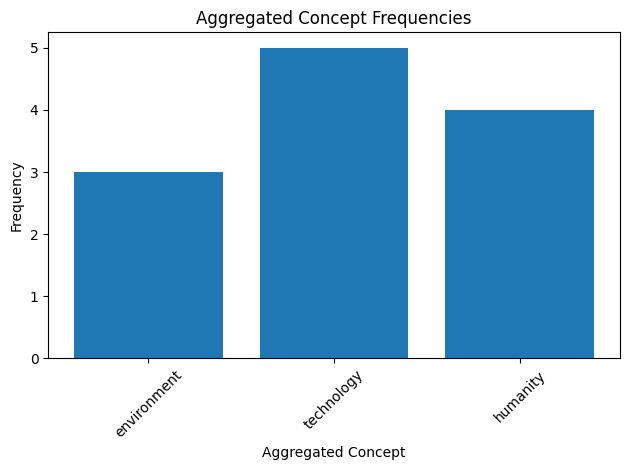



Detailed heatmap generated




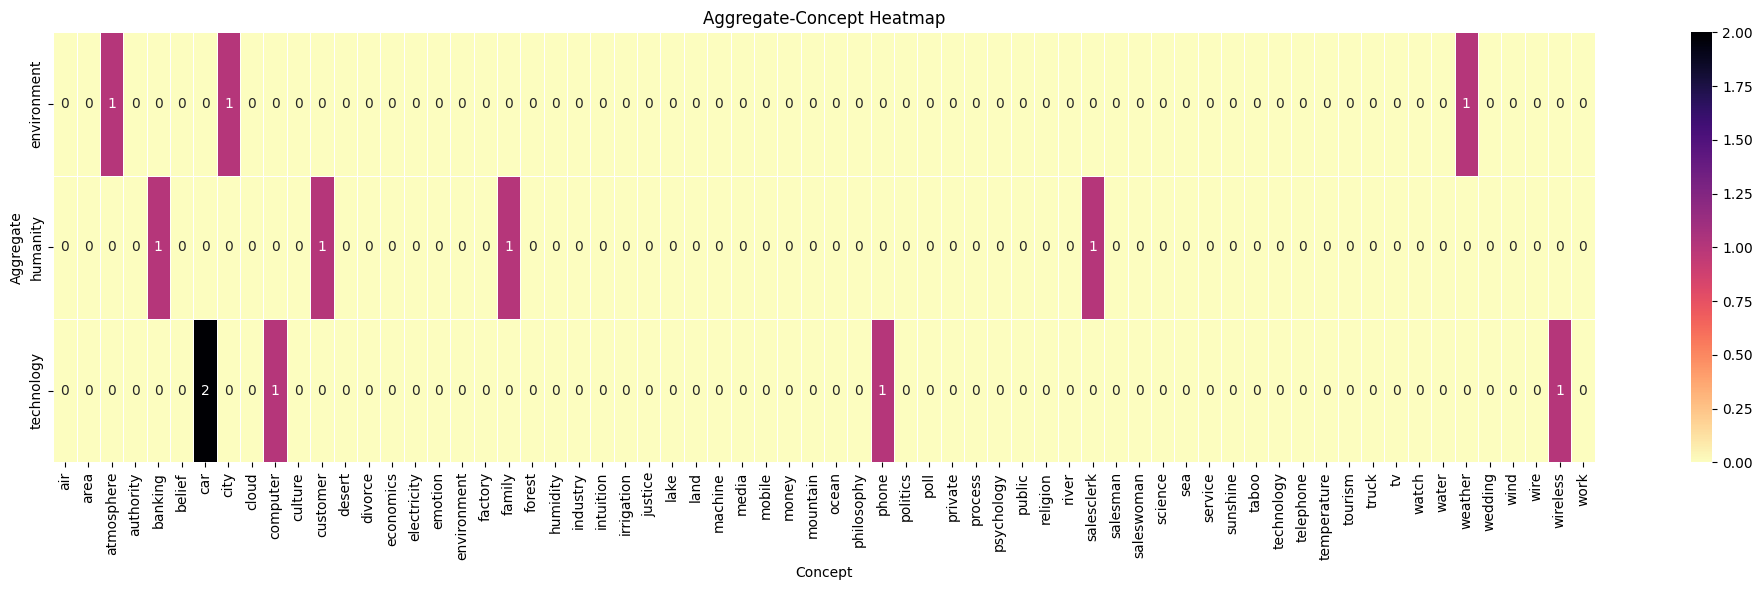

In [ ]:
# assuming a folder `text-batch` containing text files, ...
a = analyze_txt('/content/text-batch/annoying-clerk.txt')

In [ ]:
len(a)

2

In [ ]:
# JSON save
json_saver(a, output_path='./a.json')

# JSON load
h = json_loader('./a.json')
len(h)

2

# **(2) Multiple Docs**

In [ ]:
# assuming a folder `text-batch` containing text files, ...
b = batch_preprocess('./text-batch')
len(b)

11

In [ ]:
# batch JSON save to a subfolder ./batchJ
batch_json_saver(b, folderpath='./batchJ')

File ./batchJ/humor-PsychologyToday.json saved

File ./batchJ/network-creativity-PsychologyToday.json saved

File ./batchJ/hurricanes-deep-ocean-phys.org.json saved

File ./batchJ/ai-emails-PsychologyToday.json saved

File ./batchJ/oldest-phsysical-phys.org.json saved

File ./batchJ/honey-Wikipedia.json saved

File ./batchJ/retina-nanowires-phys.org.json saved

File ./batchJ/spirituality-Wikipedia.json saved

File ./batchJ/Knuth-Wikipedia.json saved

File ./batchJ/network-awakening-grok-generated.json saved

File ./batchJ/annoying-clerk.json saved



In [ ]:
# batch JSON load from a subfolder ./batchJ
bb = batch_json_loader('./batchJ')
len(bb)

11


Silhouette Score: 0.2122621941846763



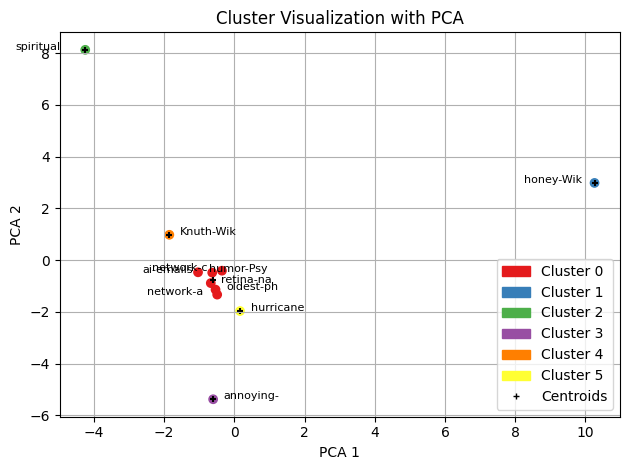

In [ ]:
# vetorize
v = vectorizer(b)

# cluster
c = cluster(v, save_name='c.png')

In [59]:
# the final DataFrame is:
c[0]

,Cluster No.,environment,technology,humanity,"('humanity', 'media')","('technology', 'tv')","('technology', 'wireless')","('humanity', 'banking')","('environment', 'atmosphere')","('environment', 'forest')",...,"('environment', 'weather')","('environment', 'lake')","('humanity', 'wedding')","('humanity', 'saleswoman')","('environment', 'temperature')","('environment', 'city')","('technology', 'truck')","('humanity', 'private')","('environment', 'water')","('technology', 'work')"
humor-PsychologyToday.txt,0,3,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
network-creativity-PsychologyToday.txt,0,0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
hurricanes-deep-ocean-phys.org.txt,5,15,0,4,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,4,0
ai-emails-PsychologyToday.txt,0,1,1,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
oldest-phsysical-phys.org.txt,0,0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
honey-Wikipedia.txt,1,87,10,3,0,0,0,0,0,0,...,1,0,0,0,17,0,0,0,48,1
retina-nanowires-phys.org.txt,0,0,2,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
spirituality-Wikipedia.txt,2,0,11,40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
Knuth-Wikipedia.txt,4,0,54,19,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
network-awakening-grok-generated.txt,0,15,0,1,0,0,0,0,0,0,...,0,0,0,0,0,14,0,0,0,0


In [60]:
# and the cluster labels are:
c[1]

array([0, 0, 5, 0, 0, 1, 0, 2, 4, 0, 3], dtype=int32)